In [51]:
import os
import cv2
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, AveragePooling2D,PReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import  confusion_matrix,precision_score,accuracy_score,recall_score,ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Nadam
import tensorflow as tf
import pandas as pd

In [52]:
URL="./Videos"


In [53]:
metricas={"precision":[],"recall":[]}

## Funciones definidas

In [54]:
def obtenerDatos(archivo):
   data=h5py.File(archivo)
   return data["X"][:],data["Y"][:] 

In [55]:
def obtener_etiquetas(url):
    labels=[]
    for index,carpeta in enumerate(os.listdir(str(url))):
        labels.append(carpeta)
    return labels

In [56]:
def normalizar(X):
    return X/255.0


In [57]:
def redimensionarData(X,ancho,largo,num_canales):
    imagenes=[]
    for imagen in X:
        img=imagen
        img=cv2.resize(img, (ancho, largo), interpolation=cv2.INTER_AREA)
        if(num_canales==1):
            img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            img = np.expand_dims(img, axis=-1) 

        imagenes.append(img)
    return np.array(imagenes)


In [58]:
def plot_image(image):
    plt.imshow(image, cmap = "gray", interpolation = "nearest")
    plt.axis("off")

## Cargamos los datos

In [59]:
X_train,y_train=obtenerDatos("./data/datos_train_color.h5")


In [63]:
X_test,y_test=obtenerDatos("./data/datos_test_color.h5")


In [64]:
X_train.shape

(2400, 200, 200, 3)

In [65]:
y_train.shape

(2400,)

In [66]:
X_test.shape

(800, 200, 200, 3)

In [67]:
y_test.shape

(800,)

## Visualizamos la data

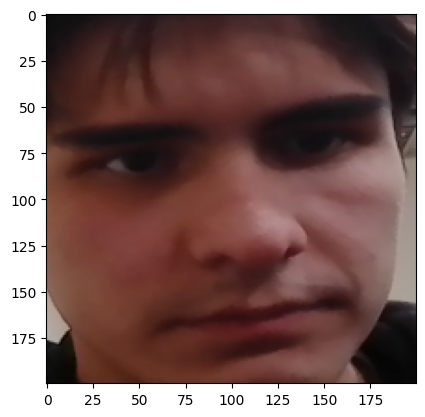

In [68]:
plt.imshow(X_train[1202])

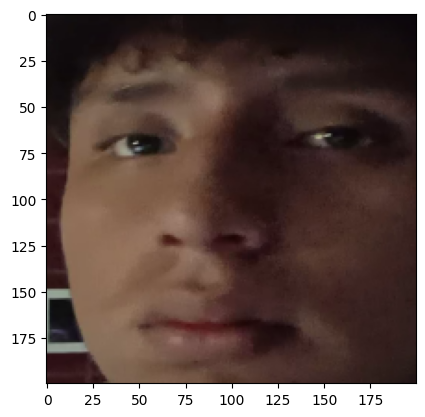

In [69]:
plt.imshow(X_train[500])

In [70]:
labels=[]

In [71]:
labels=['Agus', 'Ale', 'Noni', 'Sebas']

In [72]:
labels

['Agus', 'Ale', 'Noni', 'Sebas']

## Modelo Generico

In [73]:
class ModeloPersonalizado:
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.modelo = None
        self.historial = None
        self.predicciones = None
        self.matriz_confusion = None

    def construir_modelo(self, configuracion):
        self.modelo = Sequential()
        self.modelo.add(InputLayer(input_shape=self.input_dim))

        # agregamos las capas convolucionales
        for capa in configuracion["capas_convolucionales"]:
            if capa["activation"]=="prelu":
                self.modelo.add(Conv2D(filters=capa["neuronas"], kernel_size=capa["kernel_size"]))
                self.modelo.add(PReLU())
            else:
                self.modelo.add(Conv2D(filters=capa["neuronas"], kernel_size=capa["kernel_size"], activation=capa["activation"]))
            if "max_pooling" in capa:
                self.modelo.add(MaxPooling2D(pool_size=capa["max_pooling"]))
            elif  "avg_pooling" in capa:
                self.modelo.add(AveragePooling2D(pool_size=capa["avg_pooling"]))

        self.modelo.add(Flatten())

        # agregamos capas densas
        for capa in configuracion["capas_ocultas"]:
            if capa["activation"]=="prelu":
                    self.modelo.add(tf.keras.layers.Dense(capa["neuronas"]))
                    self.modelo.add(tf.keras.layers.PReLU())
            else:
                self.modelo.add(Dense(capa["neuronas"], activation=capa["activation"]))
            if "dropout" in capa and capa["dropout"] > 0:
                self.modelo.add(Dropout(capa["dropout"]))

        self.modelo.add(Dense(self.output_dim, activation="softmax"))

    def compilar_modelo(self, learning_rate):
        optimizer = Nadam(learning_rate=learning_rate)
        self.modelo.compile(
            optimizer=optimizer,
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

    def entrenar_modelo(self, X_train, y_train, X_val, y_val, epochs, factor_reduccion, paciencia):
        """
        Un callback en Keras es un conjunto de funciones que puedes usar para personalizar y controlar el proceso de entrenamiento del modelo
        ReduceLROnPlateau es un callback en Keras que se utiliza para reducir la tasa de aprendizaje (learning rate)
        automáticamente si una métrica(val_loss) no mejora después de un número definido de épocas (patience).
        min_lr:El learning rate no se reducirá por debajo de este valor, lo que previene que se acerque a cero.
        lr_scheduler=planificador de la tasa de aprendizaje

        Todo este trabajo se hace poruqe la tasa de aprendizaje se encarga de enontrar el j mas pequeno para los thetas
        si este j o en nuestro caso el val_loss ya no baja mucho o de la nada se subio su valor que posiblemente estemos cerca al mejor
        j o val_loss posible para los tethas y nos conviende dar pasitos mas cortos en la tasa de aprendizaje cuidando de que no sea cero con 
        min_lr
        """
        lr_scheduler = ReduceLROnPlateau(
            monitor="val_loss",
            factor=factor_reduccion,
            patience=paciencia,
            verbose=1,
            min_lr=1e-6
        )

        self.historial = self.modelo.fit(
            X_train, 
            y_train, 
            epochs=epochs, 
            validation_data=(X_val, y_val), 
            callbacks=[lr_scheduler], 
            verbose=1
        )

    def evaluar_modelo(self, X_test, y_test, labels, configuracion):
        probabilidades = self.modelo.predict(X_test)
        self.predicciones = np.argmax(probabilidades, axis=1)

        #El macro average calcula la precisión y el recall de forma independiente para cada clase. Luego toma el promedio aritmético de esas métricas.
        precision = precision_score(y_test, self.predicciones, average="macro")
        recall = recall_score(y_test, self.predicciones, average="macro")

        self.matriz_confusion = confusion_matrix(y_test, self.predicciones)

        resultados = {
            "configuracion": configuracion,
            "precision": precision,
            "recall": recall,
            "historial": self.historial.history,
            "matriz_confusion": self.matriz_confusion
        }

        return resultados

## Configramos los modelos

In [74]:
configuraciones=[ 
    ## CNN BASICA
    {
       
        "input_dims":  (32,32,3),
        "capas_convolucionales":[
          {"neuronas":32,
           "kernel_size":(3, 3),
           "activation":"relu",
           "max_pooling":(2,2)
           },
           {"neuronas":64,
           "kernel_size":(3, 3),
           "activation":"relu",
           "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [{"neuronas": 128, "activation": "relu"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
        {
       
        "input_dims":  (32,32,3),
        "capas_convolucionales":[
          {"neuronas":32,
           "kernel_size":(3, 3),
           "activation":"prelu",
           "max_pooling":(2,2)
           },
           {"neuronas":64,
           "kernel_size":(3, 3),
           "activation":"prelu",
           "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [{"neuronas": 128, "activation": "prelu"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
    ## CNN Imagenes Grandes
    {
       
        "input_dims":  (128,128,3),
        "capas_convolucionales":[
          {"neuronas":64,
           "kernel_size":(7, 7),
           "activation":"relu",
           "max_pooling":(3,3)
           },
           {"neuronas":128,
           "kernel_size":(3, 3),
           "activation":"relu",
           },
          {"neuronas":256,
           "kernel_size":(3, 3),
           "activation":"relu",
           "max_pooling":(3,3)
           }
        ],
        "capas_ocultas": [{"neuronas": 512, "activation": "relu","dropout": 0.15}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
        {
       
        "input_dims":  (128,128,3),
        "capas_convolucionales":[
          {"neuronas":64,
           "kernel_size":(7, 7),
           "activation":"prelu",
           "max_pooling":(3,3)
           },
           {"neuronas":128,
           "kernel_size":(3, 3),
           "activation":"prelu",
           },
          {"neuronas":256,
           "kernel_size":(3, 3),
           "activation":"prelu",
           "max_pooling":(3,3)
           }
        ],
        "capas_ocultas": [{"neuronas": 512, "activation": "prelu","dropout": 0.15}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },


    ## CNN Profunda
    {
       
        "input_dims":  (64,64,3),
        "capas_convolucionales":[
          {"neuronas":32,
           "kernel_size":(3, 3),
           "activation":"relu",
           },
            {"neuronas":64,
           "kernel_size":(3, 3),
           "activation":"relu",
            "max_pooling":(2,2)
           },

           {"neuronas":128,
           "kernel_size":(3, 3),
           "activation":"relu",
           },
            {"neuronas":256,
           "kernel_size":(3, 3),
           "activation":"relu",
            "max_pooling":(2,2)
           },
           {"neuronas":512,
           "kernel_size":(3, 3),
           "activation":"relu",
            "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [{"neuronas": 1024, "activation": "relu","dropout": 0.15}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
    {
       
        "input_dims":  (64,64,3),
        "capas_convolucionales":[
          {"neuronas":32,
           "kernel_size":(3, 3),
           "activation":"prelu",
           },
            {"neuronas":64,
           "kernel_size":(3, 3),
           "activation":"prelu",
            "max_pooling":(2,2)
           },

           {"neuronas":128,
           "kernel_size":(3, 3),
           "activation":"prelu",
           },
            {"neuronas":256,
           "kernel_size":(3, 3),
           "activation":"prelu",
            "max_pooling":(2,2)
           },
           {"neuronas":512,
           "kernel_size":(3, 3),
           "activation":"prelu",
            "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [{"neuronas": 1024, "activation": "prelu","dropout": 0.15}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },


    ## CNN Imagenes Grandes sin DropOut
    {
       
        "input_dims":  (128,128,3),
        "capas_convolucionales":[
          {"neuronas":64,
           "kernel_size":(7, 7),
           "activation":"relu",
           "max_pooling":(3,3)
           },
           {"neuronas":128,
           "kernel_size":(3, 3),
           "activation":"relu",
           },
          {"neuronas":256,
           "kernel_size":(3, 3),
           "activation":"relu",
           "max_pooling":(3,3)
           }
        ],
        "capas_ocultas": [{"neuronas": 512, "activation": "relu"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
    {
       
        "input_dims":  (128,128,3),
        "capas_convolucionales":[
          {"neuronas":64,
           "kernel_size":(7, 7),
           "activation":"prelu",
           "max_pooling":(3,3)
           },
           {"neuronas":128,
           "kernel_size":(3, 3),
           "activation":"prelu",
           },
          {"neuronas":256,
           "kernel_size":(3, 3),
           "activation":"prelu",
           "max_pooling":(3,3)
           }
        ],
        "capas_ocultas": [{"neuronas": 512, "activation": "prelu"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },


    ## CNN Profunda Sin Dropout
    {
       
        "input_dims":  (64,64,3),
        "capas_convolucionales":[
          {"neuronas":32,
           "kernel_size":(3, 3),
           "activation":"relu",
           },
            {"neuronas":64,
           "kernel_size":(3, 3),
           "activation":"relu",
            "max_pooling":(2,2)
           },

           {"neuronas":128,
           "kernel_size":(3, 3),
           "activation":"relu",
           },
            {"neuronas":256,
           "kernel_size":(3, 3),
           "activation":"relu",
            "max_pooling":(2,2)
           },
           {"neuronas":512,
           "kernel_size":(3, 3),
           "activation":"relu",
            "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [{"neuronas": 1024, "activation": "relu"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
    {
       
        "input_dims":  (64,64,3),
        "capas_convolucionales":[
          {"neuronas":32,
           "kernel_size":(3, 3),
           "activation":"prelu",
           },
            {"neuronas":64,
           "kernel_size":(3, 3),
           "activation":"prelu",
            "max_pooling":(2,2)
           },

           {"neuronas":128,
           "kernel_size":(3, 3),
           "activation":"prelu",
           },
            {"neuronas":256,
           "kernel_size":(3, 3),
           "activation":"prelu",
            "max_pooling":(2,2)
           },
           {"neuronas":512,
           "kernel_size":(3, 3),
           "activation":"prelu",
            "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [{"neuronas": 1024, "activation": "prelu"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },


]

In [75]:

resultados_metricas = []

for idx, config in enumerate(configuraciones):
    print(f"Entrenando modelo {idx + 1}/{len(configuraciones)}...")
    input_dims=config["input_dims"]
    X_train_copia=X_train.copy()
    X_test_copia=X_test.copy()

    X_train_copia=redimensionarData(X_train_copia,*input_dims)
    X_test_copia=redimensionarData(X_test_copia,*input_dims)
    X_train_copia=normalizar(X_train_copia)
    X_test_copia=normalizar(X_test_copia)
    print(X_train_copia.shape)
    print(X_test_copia.shape)
    

    modelo = ModeloPersonalizado(input_dim=input_dims, output_dim=4)
    modelo.construir_modelo(config)
    modelo.compilar_modelo(learning_rate=config["learning_rate"])
    modelo.entrenar_modelo(
        X_train=X_train_copia,
        y_train=y_train,
        X_val=X_test_copia,
        y_val=y_test,
        epochs=15,
        factor_reduccion=config["factor_reduccion"],
        paciencia=5,
    )
    
    resultados = modelo.evaluar_modelo(
        X_test=X_test_copia,
        y_test=y_test,
        labels=labels,
        configuracion=config
    )
    resultados_metricas.append(resultados)

    print(f"Modelo {idx + 1} se acabo de entrenar y se guardo")

df_resultados = pd.DataFrame(resultados_metricas)


Entrenando modelo 1/10...
(2400, 32, 32, 3)
(800, 32, 32, 3)
Epoch 1/15


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6381 - loss: 0.8069 - val_accuracy: 0.4938 - val_loss: 4.6830 - learning_rate: 0.0010
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9981 - loss: 0.0106 - val_accuracy: 0.4850 - val_loss: 6.9030 - learning_rate: 0.0010
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9993 - loss: 0.0078 - val_accuracy: 0.4087 - val_loss: 2.8323 - learning_rate: 0.0010
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.4300 - val_loss: 4.8074 - learning_rate: 0.0010
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 6.2801e-04 - val_accuracy: 0.4837 - val_loss: 5.0582 - learning_rate: 0.0010
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 5.4158e-04 - val_accuracy: 0.4087 - val_loss: 4.2601 - learning_rate: 0.0010
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 3.1712e-04 - val_ac

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(2400, 32, 32, 3)
(800, 32, 32, 3)
Epoch 1/15


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.6487 - loss: 0.7853 - val_accuracy: 0.4613 - val_loss: 4.6707 - learning_rate: 0.0010
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9934 - loss: 0.0253 - val_accuracy: 0.4563 - val_loss: 4.3145 - learning_rate: 0.0010
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.4575 - val_loss: 4.5750 - learning_rate: 0.0010
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.4550 - val_loss: 3.9257 - learning_rate: 0.0010
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 1.0000 - loss: 8.2931e-04 - val_accuracy: 0.4575 - val_loss: 4.7615 - learning_rate: 0.0010
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 1.0000 - loss: 2.8195e-04 - val_accuracy: 0.4550 - val_loss: 4.3265 - learning_rate: 0.0010
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 1.0000 - loss: 1.2792e-04 - val_a

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(2400, 128, 128, 3)
(800, 128, 128, 3)


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.6700 - loss: 0.8031 - val_accuracy: 0.4363 - val_loss: 4.0598 - learning_rate: 0.0010
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9940 - loss: 0.0211 - val_accuracy: 0.4288 - val_loss: 2.9394 - learning_rate: 0.0010
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9727 - loss: 0.1024 - val_accuracy: 0.4725 - val_loss: 6.4000 - learning_rate: 0.0010
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9984 - loss: 0.0063 - val_accuracy: 0.4400 - val_loss: 5.1669 - learning_rate: 0.0010
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9993 - loss: 0.0020 - val_accuracy: 0.4387 - val_loss: 6.0483 - learning_rate: 0.0010
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 1.0000 - loss: 2.7135e-04 - val_accuracy: 0.4387 - val_loss: 6.9041 - learning_rate: 0.0010
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 1.4561e-04
Epoch 7:

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(2400, 128, 128, 3)
(800, 128, 128, 3)


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.6720 - loss: 0.9697 - val_accuracy: 0.4538 - val_loss: 4.4001 - learning_rate: 0.0010
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.9973 - loss: 0.0110 - val_accuracy: 0.4750 - val_loss: 5.2171 - learning_rate: 0.0010
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.9810 - loss: 0.2463 - val_accuracy: 0.4162 - val_loss: 3.6267 - learning_rate: 0.0010
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.9925 - loss: 0.0271 - val_accuracy: 0.4900 - val_loss: 5.6946 - learning_rate: 0.0010
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.9977 - loss: 0.0092 - val_accuracy: 0.5275 - val_loss: 6.4810 - learning_rate: 0.0010
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9994 - loss: 0.0030 - val_accuracy: 0.4950 - val_loss: 10.6224 - learning_rate: 0.0010
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9969 - loss: 0.0070 - val_ac

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 79s 926ms/step - accuracy: 0.5554 - loss: 1.2105 - val_accuracy: 0.4663 - val_loss: 4.5220 - learning_rate: 0.0010
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 69s 922ms/step - accuracy: 0.9908 - loss: 0.0287 - val_accuracy: 0.5000 - val_loss: 6.5726 - learning_rate: 0.0010
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 69s 929ms/step - accuracy: 0.9927 - loss: 0.0190 - val_accuracy: 0.4588 - val_loss: 4.7832 - learning_rate: 0.0010
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 69s 924ms/step - accuracy: 0.9992 - loss: 9.8842e-04 - val_accuracy: 0.4512 - val_loss: 5.4725 - learning_rate: 0.0010
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 69s 919ms/step - accuracy: 1.0000 - loss: 7.6420e-05 - val_accuracy: 0.4437 - val_loss: 5.7826 - learning_rate: 0.0010
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 880ms/step - accuracy: 1.0000 - loss: 2.1220e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
75/75 ━━━━━━━━━━━━━━━━━━━━ 68s 913ms/step - accuracy: 1.0000

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(2400, 64, 64, 3)
(800, 64, 64, 3)


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.5282 - loss: 1.0443 - val_accuracy: 0.4125 - val_loss: 1.9902 - learning_rate: 0.0010
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9927 - loss: 0.0275 - val_accuracy: 0.4600 - val_loss: 5.6594 - learning_rate: 0.0010
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9987 - loss: 0.0036 - val_accuracy: 0.4487 - val_loss: 5.8258 - learning_rate: 0.0010
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 1.0000 - loss: 3.9185e-04 - val_accuracy: 0.4500 - val_loss: 6.5058 - learning_rate: 0.0010
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 1.0000 - loss: 3.0187e-05 - val_accuracy: 0.4500 - val_loss: 6.8679 - learning_rate: 0.0010
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 6.2341e-05
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
75/75 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 1.0000 - loss: 6.2169e-05 -

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(2400, 128, 128, 3)
(800, 128, 128, 3)


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.5329 - loss: 1.1891 - val_accuracy: 0.4663 - val_loss: 5.0613 - learning_rate: 0.0010
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9948 - loss: 0.0142 - val_accuracy: 0.3975 - val_loss: 6.4204 - learning_rate: 0.0010
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9996 - loss: 0.0011 - val_accuracy: 0.4725 - val_loss: 3.8043 - learning_rate: 0.0010
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9986 - loss: 0.0038 - val_accuracy: 0.4300 - val_loss: 7.6864 - learning_rate: 0.0010
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9999 - loss: 3.1555e-04 - val_accuracy: 0.3875 - val_loss: 3.9636 - learning_rate: 0.0010
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.4675 - val_loss: 7.1847 - learning_rate: 0.0010
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 1.0000 - loss: 2.5255e-05 - val_ac

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.5498 - loss: 1.1409 - val_accuracy: 0.4038 - val_loss: 3.1219 - learning_rate: 0.0010
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9988 - loss: 0.0056 - val_accuracy: 0.4062 - val_loss: 4.4777 - learning_rate: 0.0010
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 1.0000 - loss: 6.1995e-04 - val_accuracy: 0.3975 - val_loss: 5.7408 - learning_rate: 0.0010
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 1.0000 - loss: 8.1351e-05 - val_accuracy: 0.4000 - val_loss: 6.0979 - learning_rate: 0.0010
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 1.0000 - loss: 5.1951e-05 - val_accuracy: 0.4013 - val_loss: 6.0770 - learning_rate: 0.0010
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 3.7777e-05
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
75/75 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 1.0000 - loss: 3.7705e-

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 77s 910ms/step - accuracy: 0.5209 - loss: 1.1030 - val_accuracy: 0.1513 - val_loss: 3.1580 - learning_rate: 0.0010
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 66s 887ms/step - accuracy: 0.9974 - loss: 0.0118 - val_accuracy: 0.2188 - val_loss: 6.1151 - learning_rate: 0.0010
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 64s 839ms/step - accuracy: 0.9998 - loss: 7.3421e-04 - val_accuracy: 0.2225 - val_loss: 5.0115 - learning_rate: 0.0010
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 66s 860ms/step - accuracy: 1.0000 - loss: 1.6798e-04 - val_accuracy: 0.1975 - val_loss: 5.3746 - learning_rate: 0.0010
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 69s 893ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.2975 - val_loss: 5.3397 - learning_rate: 0.0010
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - accuracy: 1.0000 - loss: 1.2945e-05
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 868ms/step - accuracy: 1.0000

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.5291 - loss: 1.0412 - val_accuracy: 0.4538 - val_loss: 8.1967 - learning_rate: 0.0010
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9950 - loss: 0.0151 - val_accuracy: 0.4850 - val_loss: 3.0646 - learning_rate: 0.0010
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9993 - loss: 0.0022 - val_accuracy: 0.4600 - val_loss: 4.5771 - learning_rate: 0.0010
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 1.0000 - loss: 4.9430e-05 - val_accuracy: 0.4588 - val_loss: 4.9211 - learning_rate: 0.0010
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 1.0000 - loss: 7.2726e-05 - val_accuracy: 0.4550 - val_loss: 5.0082 - learning_rate: 0.0010
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 1.0000 - loss: 9.8001e-06 - val_accuracy: 0.4550 - val_loss: 5.0666 - learning_rate: 0.0010
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 1.1058e-05
E

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Modelo 1:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 128 neuronas, activación='relu', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.2830
Recall: 0.4487

Graficando historial de entrenamiento...


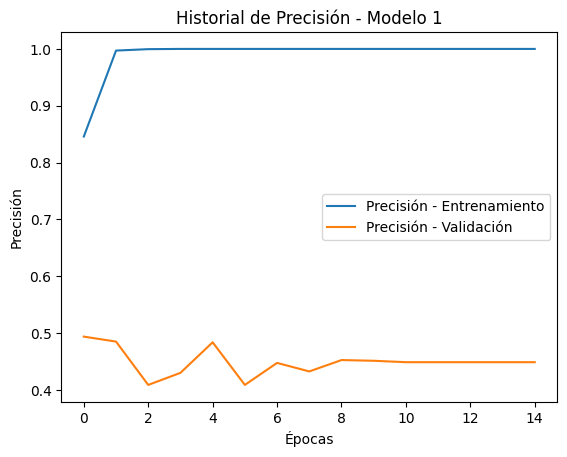

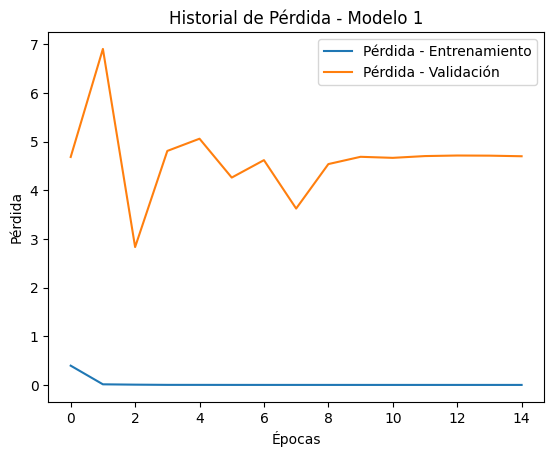


Matriz de Confusión:


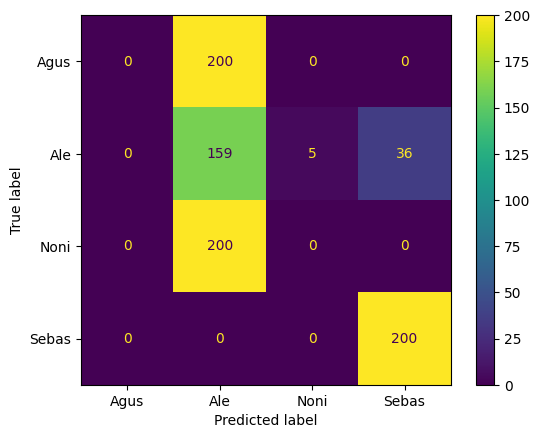



Modelo 2:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 128 neuronas, activación='prelu', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.2857
Recall: 0.4550

Graficando historial de entrenamiento...


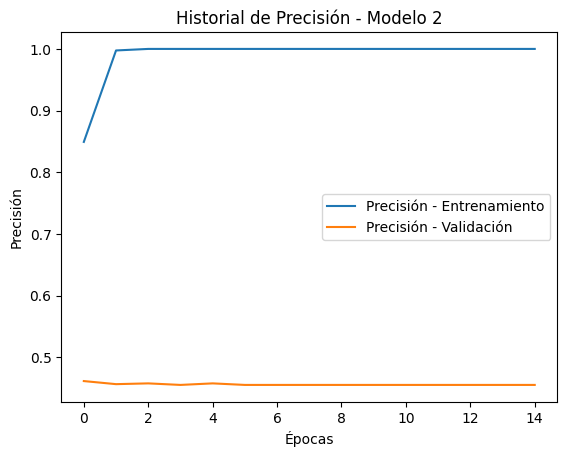

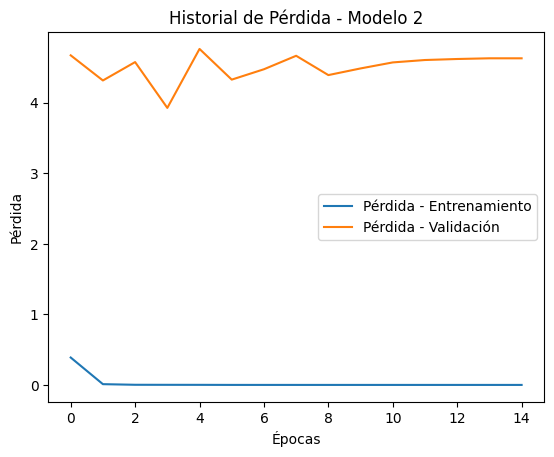


Matriz de Confusión:


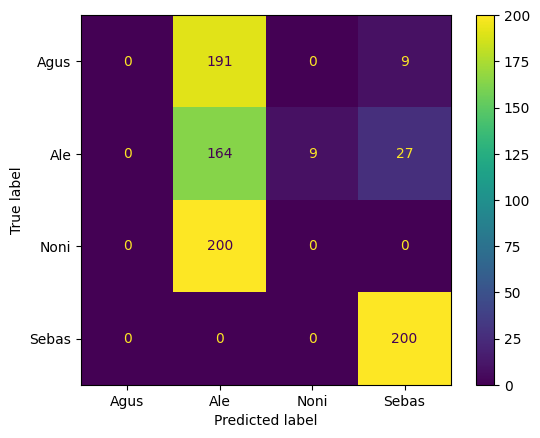



Modelo 3:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 512 neuronas, activación='relu', dropout=0.15
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.3187
Recall: 0.4375

Graficando historial de entrenamiento...


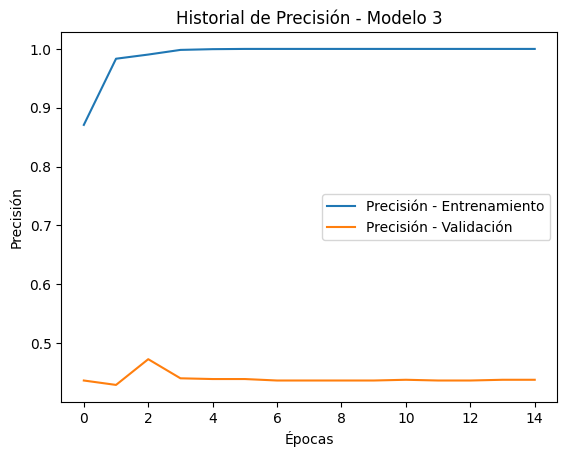

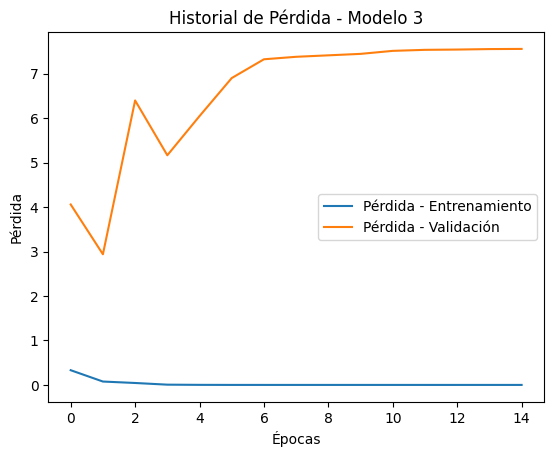


Matriz de Confusión:


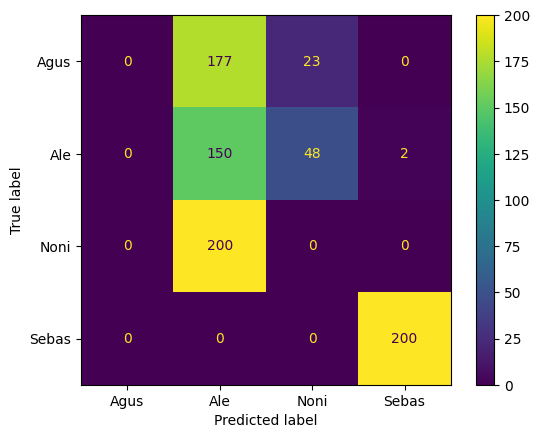



Modelo 4:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 512 neuronas, activación='prelu', dropout=0.15
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.3869
Recall: 0.4487

Graficando historial de entrenamiento...


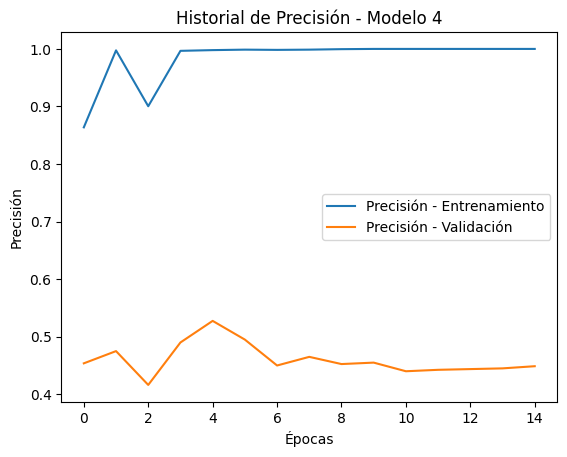

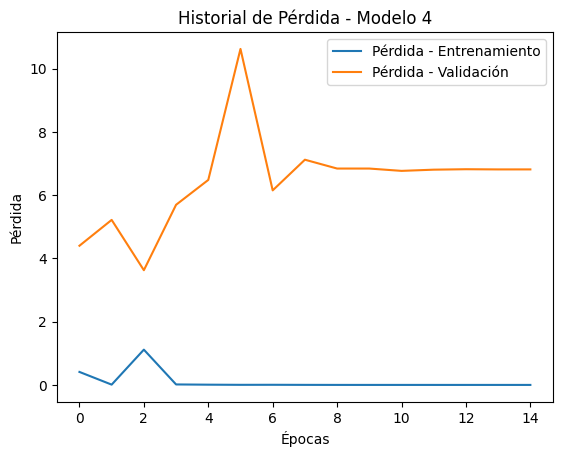


Matriz de Confusión:


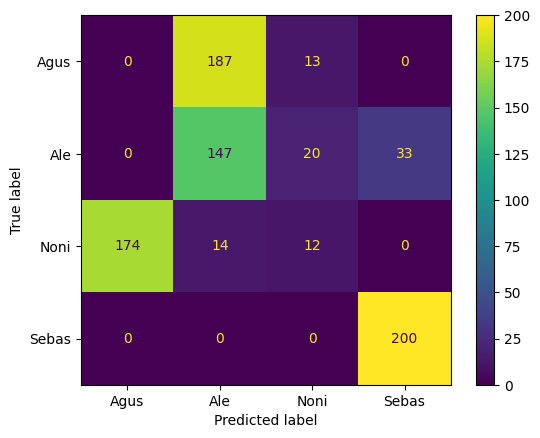



Modelo 5:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 1024 neuronas, activación='relu', dropout=0.15
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.2904
Recall: 0.4525

Graficando historial de entrenamiento...


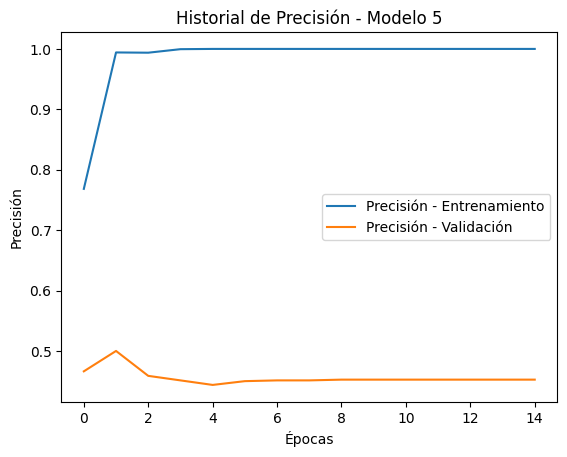

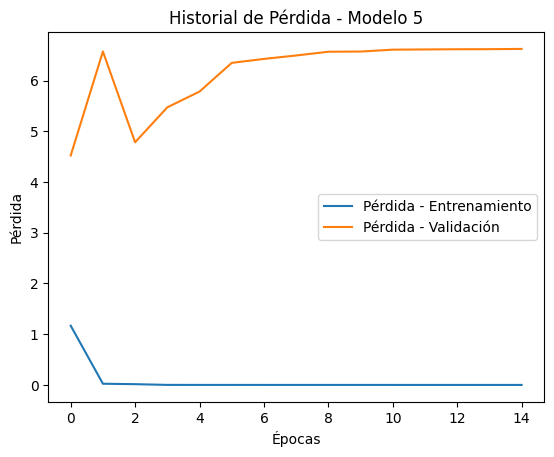


Matriz de Confusión:


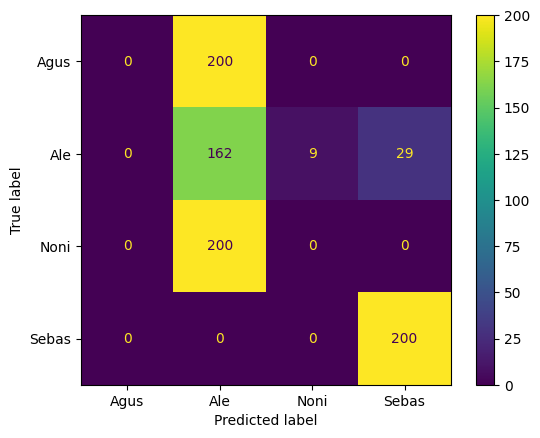



Modelo 6:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 1024 neuronas, activación='prelu', dropout=0.15
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.2865
Recall: 0.4500

Graficando historial de entrenamiento...


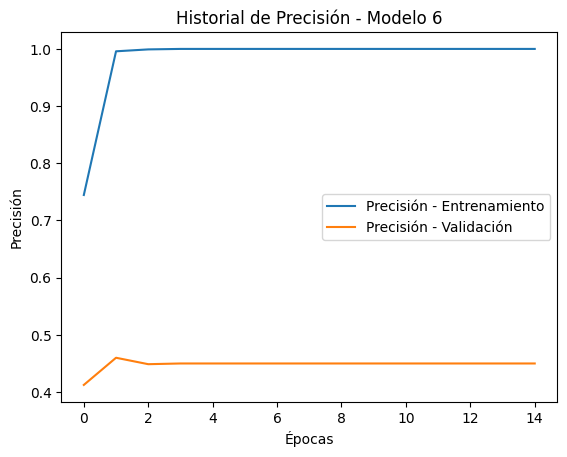

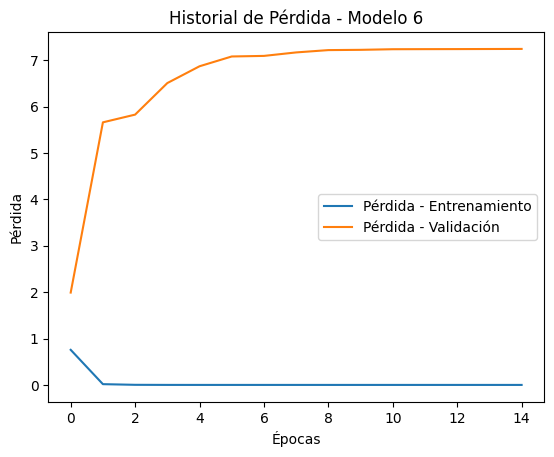


Matriz de Confusión:


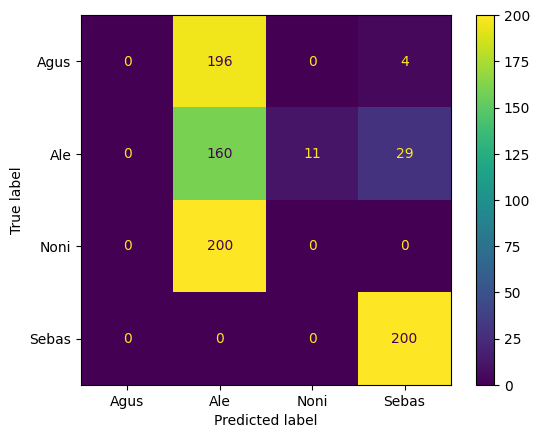



Modelo 7:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 512 neuronas, activación='relu', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.3806
Recall: 0.4487

Graficando historial de entrenamiento...


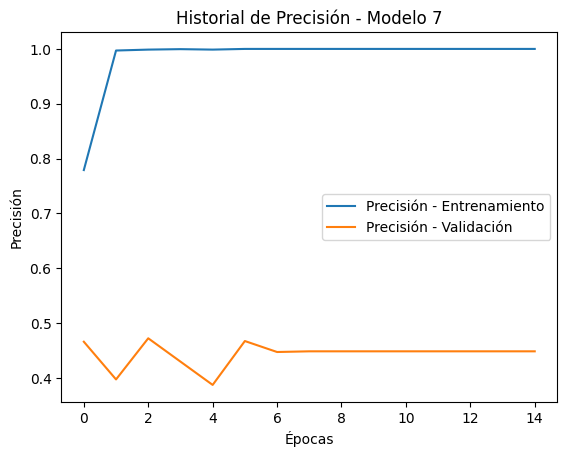

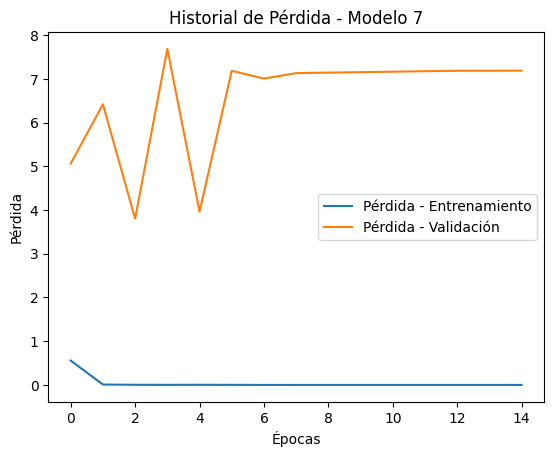


Matriz de Confusión:


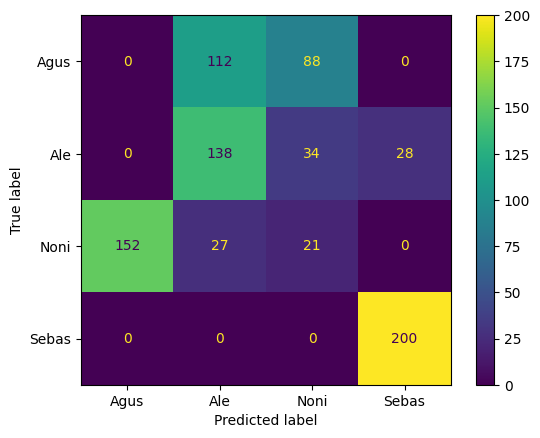



Modelo 8:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 512 neuronas, activación='prelu', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.2741
Recall: 0.4012

Graficando historial de entrenamiento...


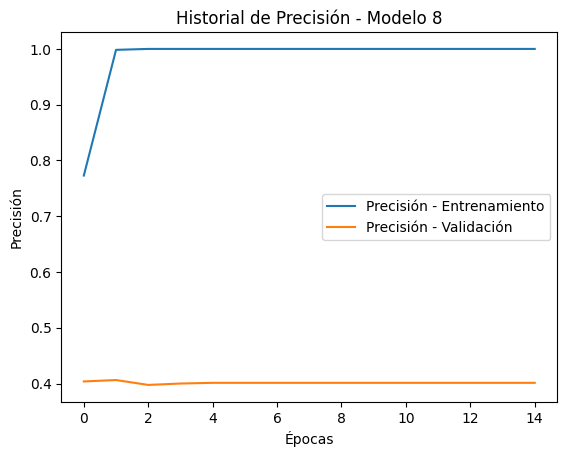

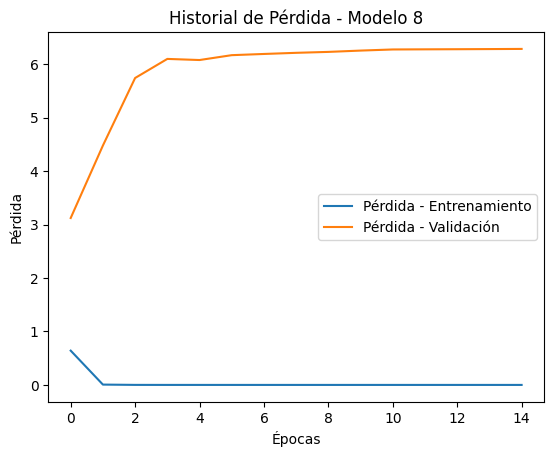


Matriz de Confusión:


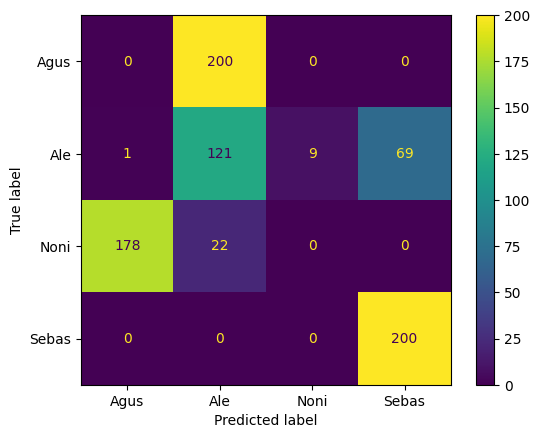



Modelo 9:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 1024 neuronas, activación='relu', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.2858
Recall: 0.3200

Graficando historial de entrenamiento...


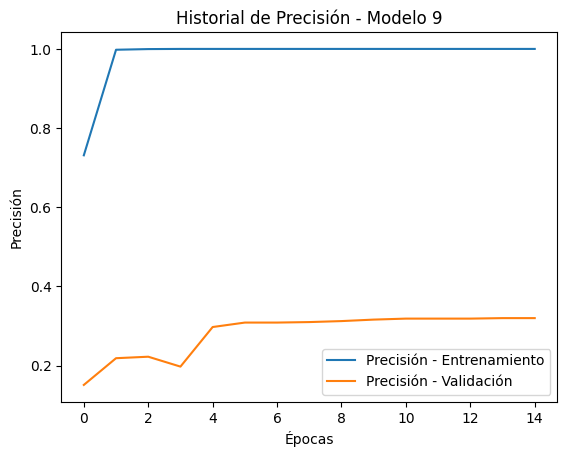

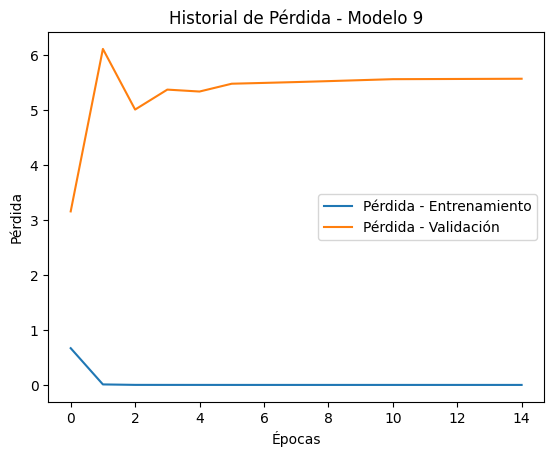


Matriz de Confusión:


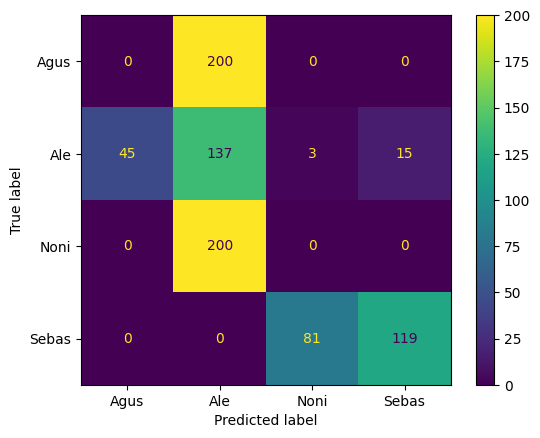



Modelo 10:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 1024 neuronas, activación='prelu', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.2949
Recall: 0.4550

Graficando historial de entrenamiento...


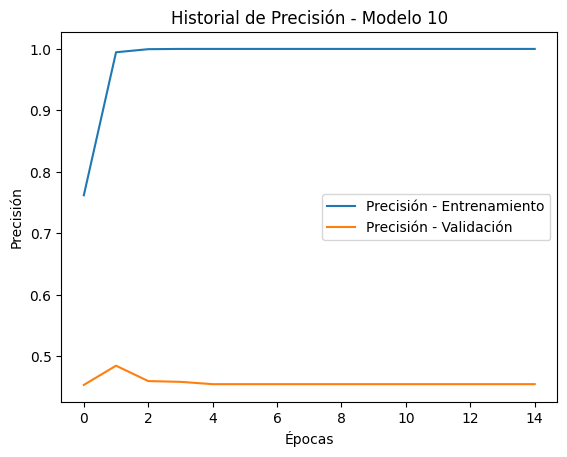

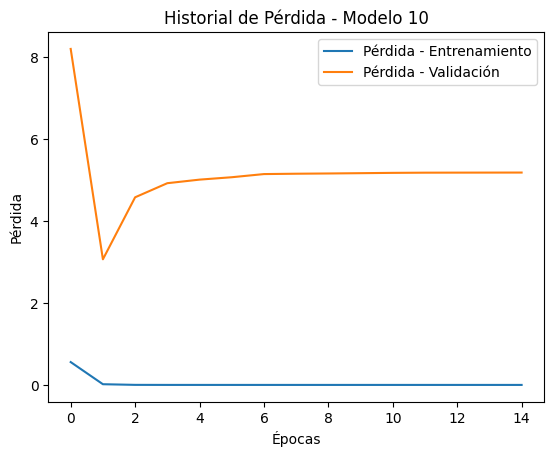


Matriz de Confusión:


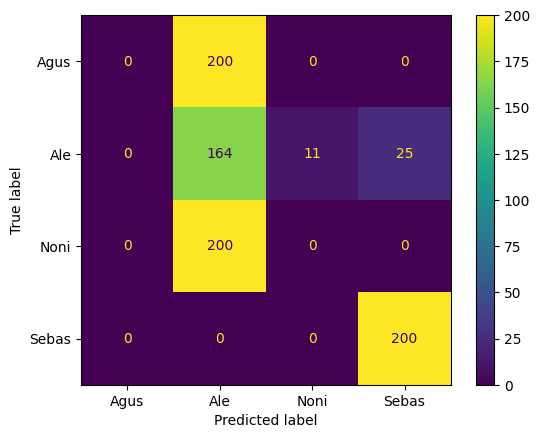

In [76]:
def mostrar_configuracion(configuracion):
    salida = []
    salida.append("Capas Ocultas:")
    for i, capa in enumerate(configuracion["capas_ocultas"]):
        salida.append(f"  Capa {i + 1}: {capa['neuronas']} neuronas, activación='{capa['activation']}', dropout={capa.get('dropout', 0)}")
    salida.append(f"Learning Rate: {configuracion['learning_rate']}")
    salida.append(f"Factor de Reducción: {configuracion['factor_reduccion']}")
    salida.append(f"Salida: {configuracion['output']['neuronas']} neuronas, activación='{configuracion['output']['activation']}'")
    return "\n".join(salida)

def mostrar_todo_dataframe(df, labels):
    for index, fila in df.iterrows():
        print(f"Modelo {index + 1}:")
        print("-" * 40)
        
        print("Configuración del modelo:")
        print(mostrar_configuracion(fila["configuracion"]))
        
        print("\nMétricas del modelo:")
        print(f"Precisión: {fila['precision']:.4f}")
        print(f"Recall: {fila['recall']:.4f}")
        
        historial = fila["historial"]
        print("\nGraficando historial de entrenamiento...")
        plt.plot(historial["accuracy"], label="Precisión - Entrenamiento")
        plt.plot(historial["val_accuracy"], label="Precisión - Validación")
        plt.title(f"Historial de Precisión - Modelo {index + 1}")
        plt.xlabel("Épocas")
        plt.ylabel("Precisión")
        plt.legend()
        plt.show()

        plt.plot(historial["loss"], label="Pérdida - Entrenamiento")
        plt.plot(historial["val_loss"], label="Pérdida - Validación")
        plt.title(f"Historial de Pérdida - Modelo {index + 1}")
        plt.xlabel("Épocas")
        plt.ylabel("Pérdida")
        plt.legend()
        plt.show()

        print("\nMatriz de Confusión:")
        cm_display = ConfusionMatrixDisplay(fila["matriz_confusion"], display_labels=labels)
        cm_display.plot()
        plt.show()

        print("\n" + "=" * 50 + "\n")

mostrar_todo_dataframe(df_resultados, labels=labels)
